In [1]:
%config InlineBackend.figure_format = 'retina'

from utils.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import time
import progressbar
import warnings

sns.set()
warnings.filterwarnings('ignore')

# stl

In [2]:
ts = get_flow_series_by_idx(6)
ts = ts.resample('15min').sum()

test_size = 4*24*7
train_ts = ts[:-test_size]
test_ts = ts[-test_size:]

decomposition = seasonal_decompose(train_ts, period=4*24, two_sided=False)  # 末尾不缺失

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

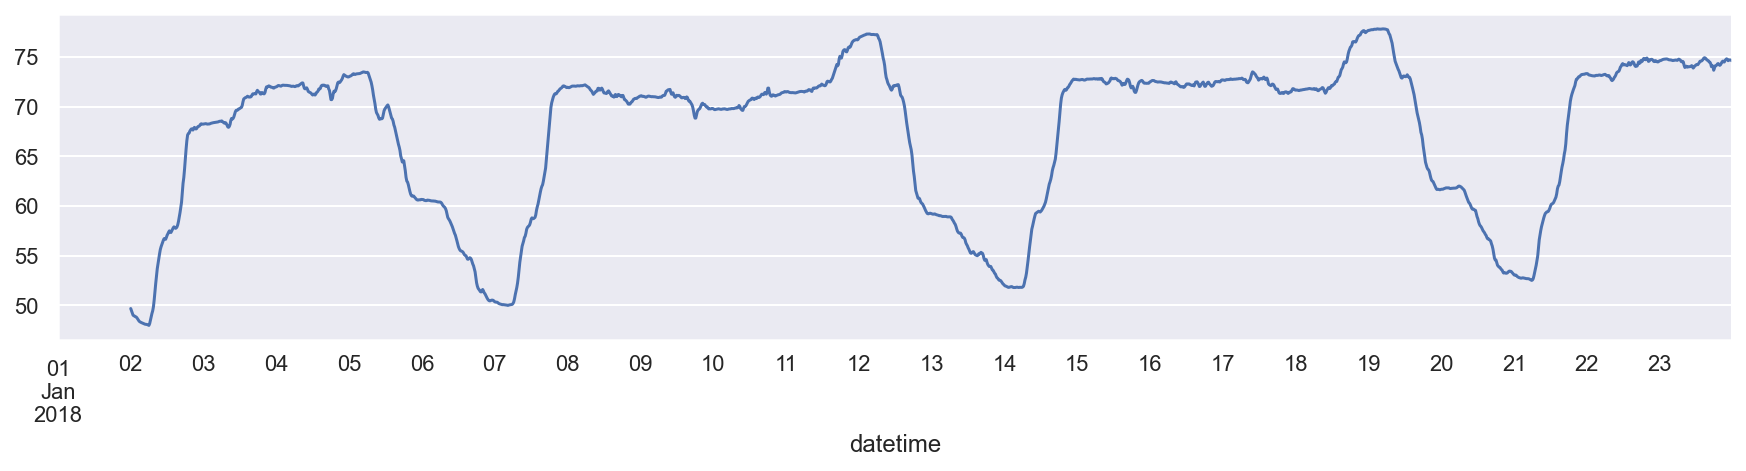

In [3]:
trend.plot(figsize=(15,3))

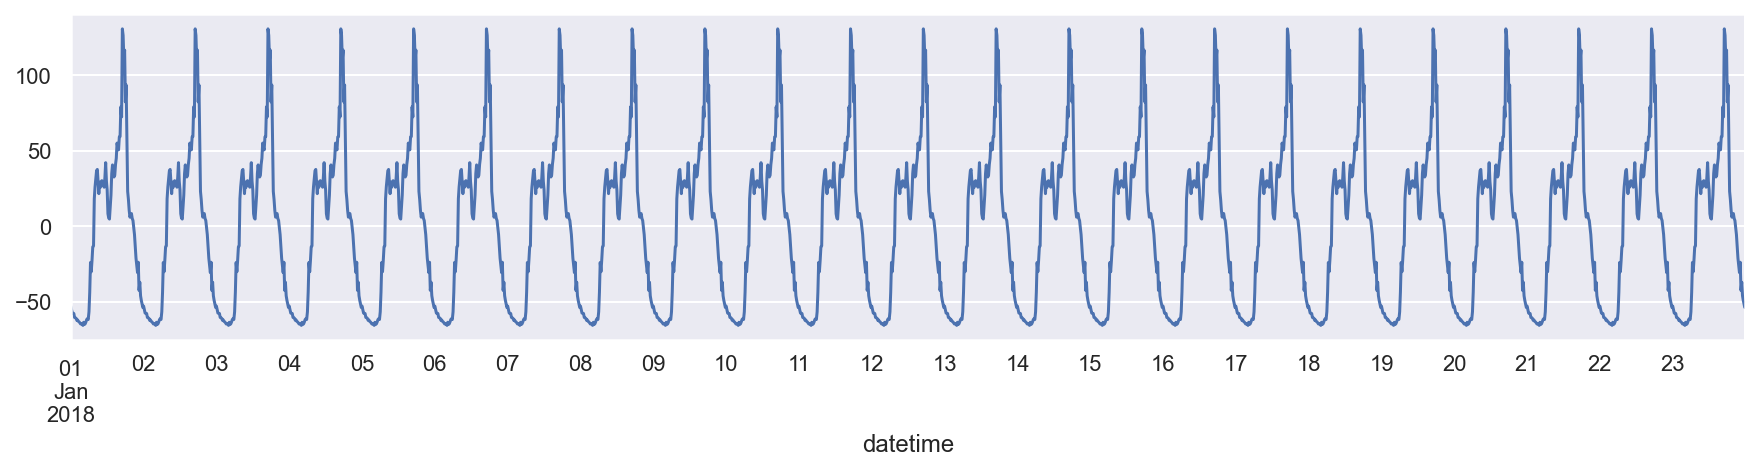

In [4]:
seasonal.plot(figsize=(15,3))

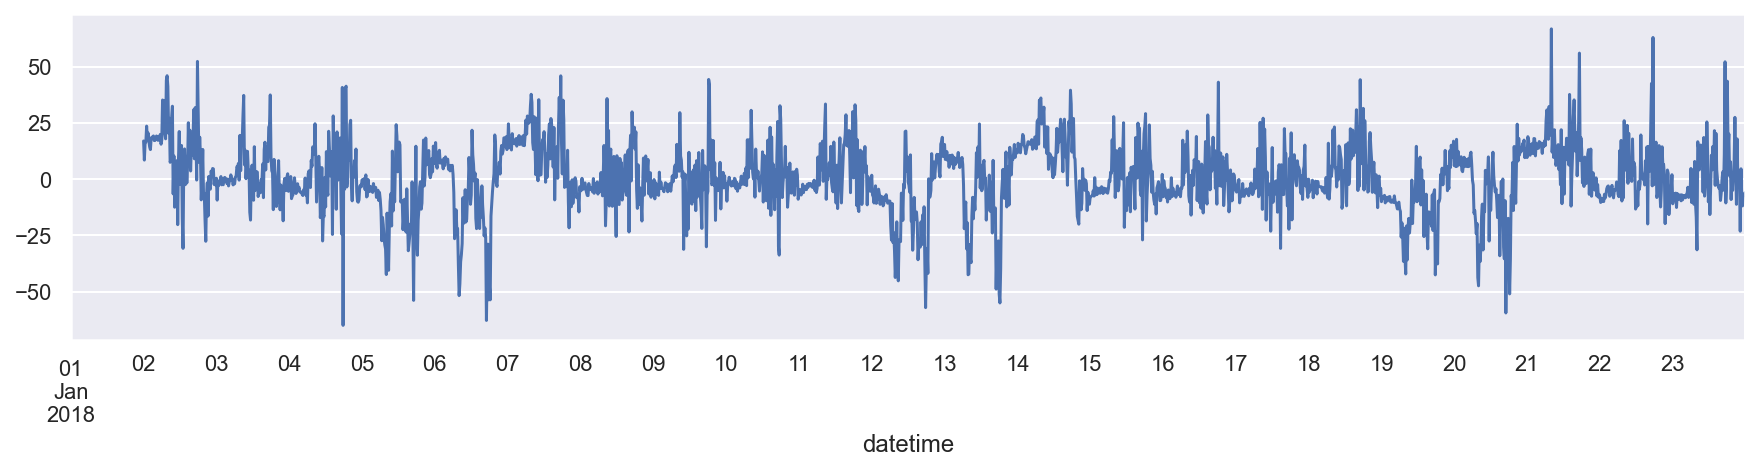

In [5]:
residual.plot(figsize=(15,3))

# stationary

目测trend不够平稳，需要差分，而residual比较平稳

## ADF

In [6]:
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

diff(trend.dropna())  # 不需要差分

timeseries_adf :  (-4.157351274813493, 0.0007774165974796012, 25, 2086, {'1%': -3.433488717753819, '5%': -2.862926547902014, '10%': -2.5675081335553003}, -4397.640770407116)
timeseries_diff1_adf :  (-4.927309816003051, 3.084785232774662e-05, 26, 2085, {'1%': -3.4334902249934984, '5%': -2.862927213384133, '10%': -2.5675084878859504}, -4389.159301734498)
timeseries_diff2_adf :  (-14.009987877461723, 3.728688595334735e-26, 25, 2086, {'1%': -3.433488717753819, '5%': -2.862926547902014, '10%': -2.5675081335553003}, -4365.942404728091)


In [7]:
diff(residual.dropna())  # 不需要差分

timeseries_adf :  (-8.316789129535396, 3.6624655211839027e-13, 11, 2100, {'1%': -3.43346776730731, '5%': -2.8629172977475434, '10%': -2.567503208390023}, 15943.844304851667)
timeseries_diff1_adf :  (-13.784934242668006, 9.149432057871123e-26, 26, 2085, {'1%': -3.4334902249934984, '5%': -2.862927213384133, '10%': -2.5675084878859504}, 15992.891519198132)
timeseries_diff2_adf :  (-16.049483998492338, 5.795652008260942e-29, 26, 2085, {'1%': -3.4334902249934984, '5%': -2.862927213384133, '10%': -2.5675084878859504}, 16170.303484612454)


## trend

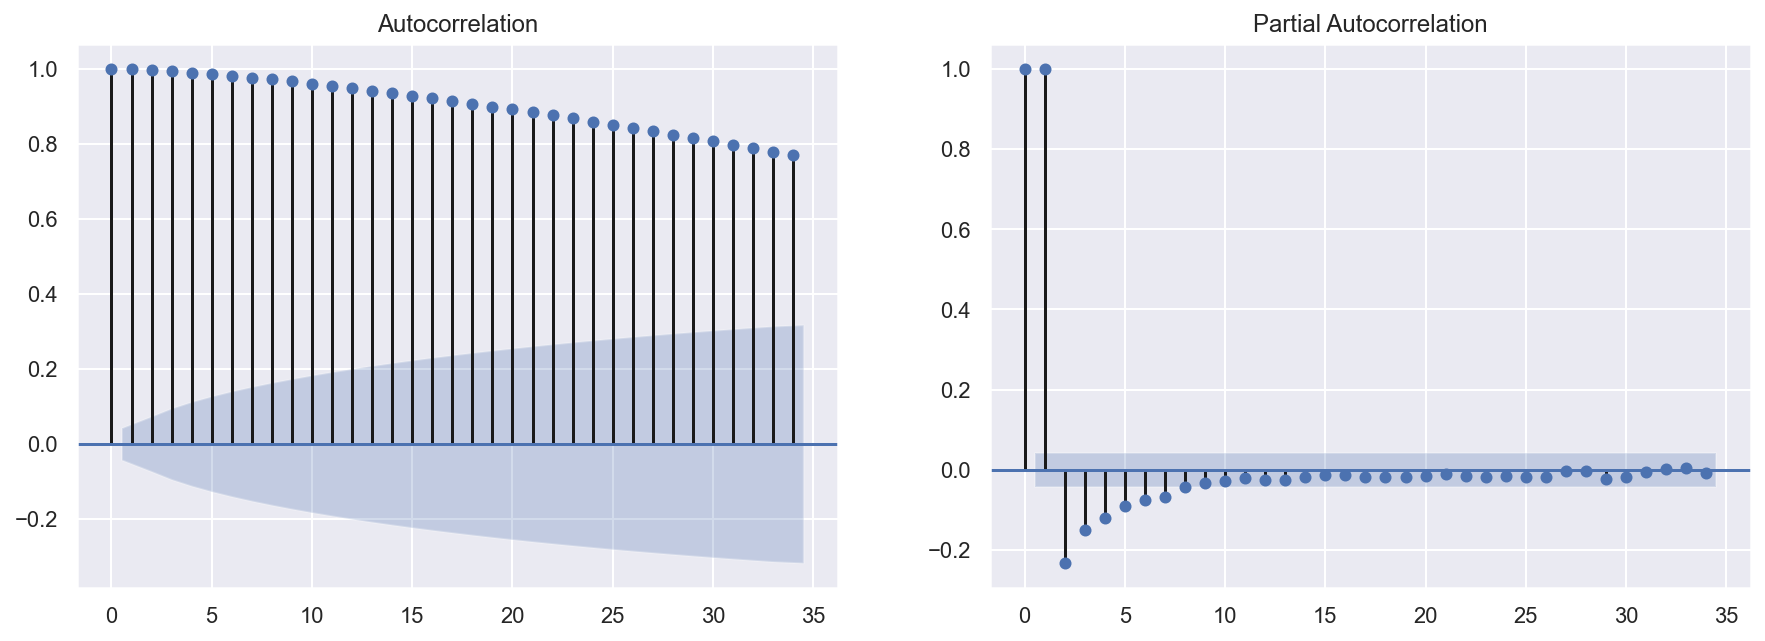

In [8]:
# org trend
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(trend.dropna(), ax=plt.gca())
plt.subplot(122)
plot_pacf(trend.dropna(), ax=plt.gca())
plt.show()

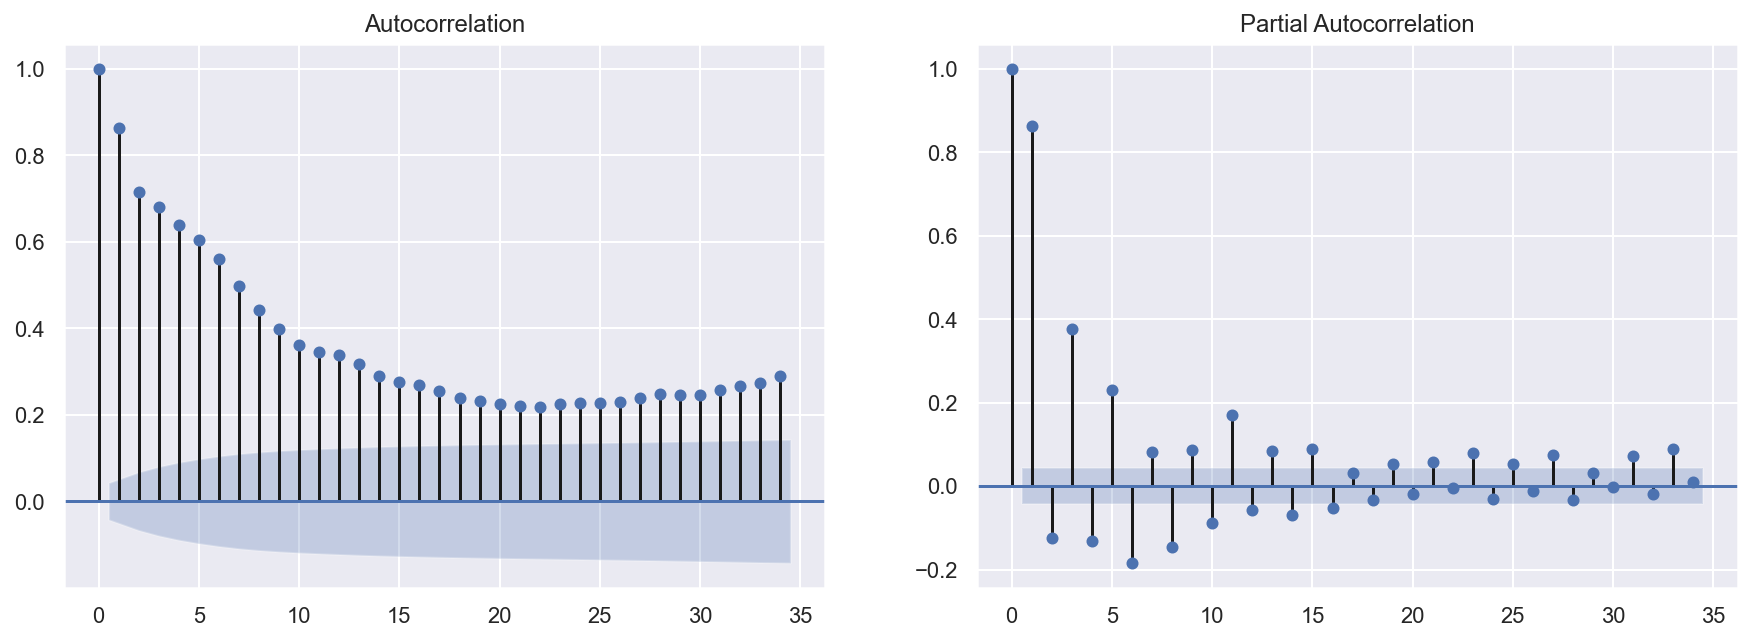

In [9]:
# diff trend
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(trend.diff(1).dropna(), ax=plt.gca())
plt.subplot(122)
plot_pacf(trend.diff(1).dropna(), ax=plt.gca())
plt.show()

## residual

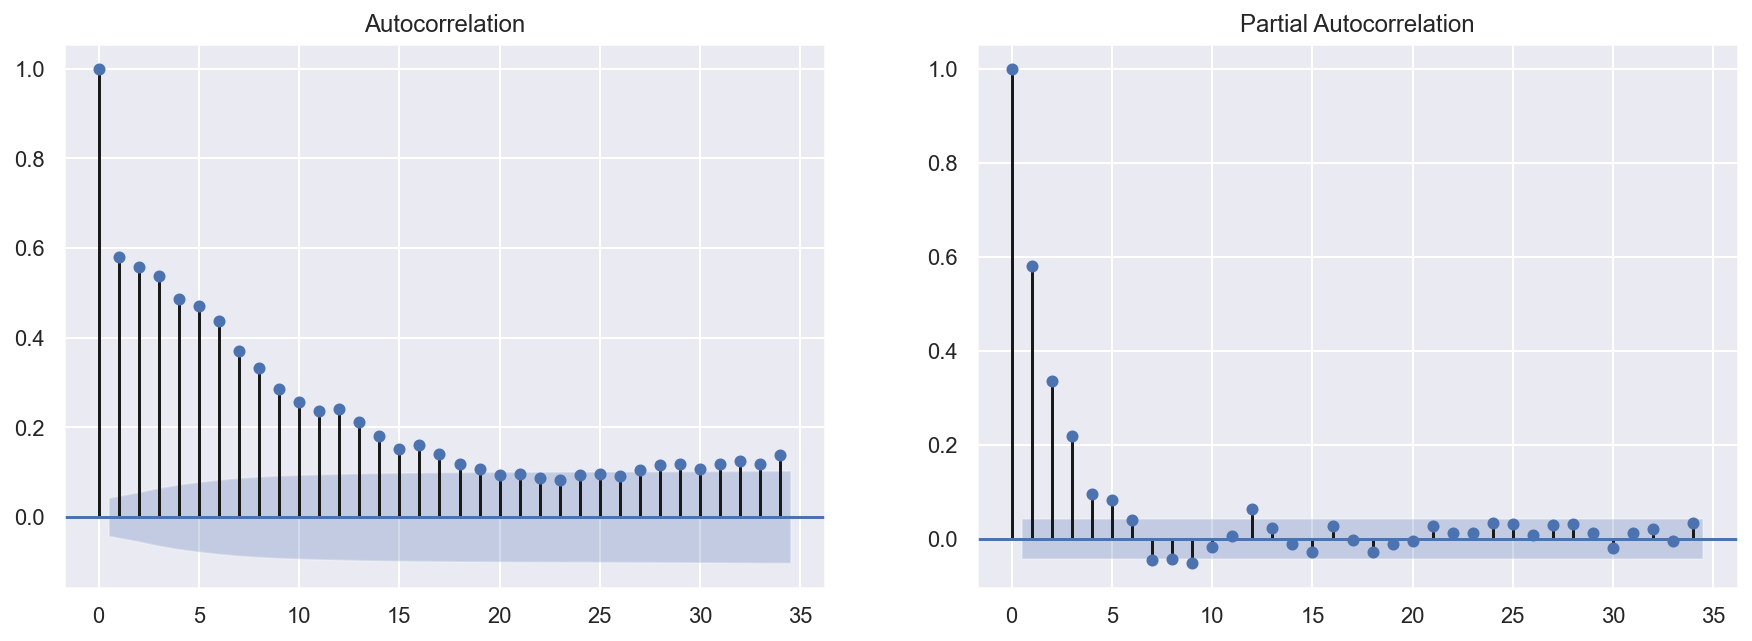

In [10]:
# org residual
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_acf(residual.dropna(), ax=plt.gca())
plt.subplot(122)
plot_pacf(residual.dropna(), ax=plt.gca())
plt.show()

# model

## trend

In [ ]:
train_ts = ts.iloc[0:-test_size]
test_ts = ts.iloc[-test_size:]

history_lst = train_ts.tolist()
test_lst = test_ts.tolist()
trend_pred = []

order = auto_arima(trend.dropna()).order
print('order:', order)

trend_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).trend
trend_arr = trend_arr[np.isfinite(trend_arr)]
model = ARIMA(trend_arr, order=order).fit()
trend_pred.append(model.forecast()[0][0])

p = progressbar.ProgressBar()
for i in p(range(test_size-1)):
    history_lst.append(test_lst[i])
    trend_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).trend
    trend_arr = trend_arr[np.isfinite(trend_arr)]
    model = ARIMA(trend_arr, order=order).fit()
    trend_pred.append(model.forecast()[0][0])

trend_pred = np.array(trend_pred)

order: (3, 1, 3)


 53% (361 of 671) |###########           | Elapsed Time: 0:14:30 ETA:   0:21:21

## residual

In [ ]:
train_ts = ts.iloc[0:-test_size]
test_ts = ts.iloc[-test_size:]

history_lst = train_ts.tolist()
test_lst = test_ts.tolist()
residual_pred = []

order = auto_arima(residual.dropna()).order
print('order:', order)  # (3,0,2)

residual_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).resid
residual_arr = residual_arr[np.isfinite(residual_arr)]
model = ARIMA(residual_arr, order=order).fit()
residual_pred.append(model.forecast()[0][0])

p = progressbar.ProgressBar()
for i in p(range(test_size-1)):
    history_lst.append(test_lst[i])
    residual_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).resid
    residual_arr = residual_arr[np.isfinite(residual_arr)]
    model = ARIMA(residual_arr, order=order).fit()
    residual_pred.append(model.forecast()[0][0])

residual_pred = np.array(residual_pred)

## seasonal

In [ ]:
train_ts = ts.iloc[0:-test_size]
test_ts = ts.iloc[-test_size:]

history_lst = train_ts.tolist()
test_lst = test_ts.tolist()
seasonal_pred = []

seasonal_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).seasonal
seasonal_pred.append(seasonal_arr[-test_size])

p = progressbar.ProgressBar()
for i in p(range(test_size-1)):
    history_lst.append(test_lst[i])
    seasonal_arr = seasonal_decompose(history_lst, period=4*24, two_sided=False).seasonal
    seasonal_pred.append(seasonal_arr[-test_size])

seasonal_pred = np.array(seasonal_pred)

## sum

In [ ]:
y_pred = trend_pred + seasonal_pred + residual_pred

In [ ]:
y_true = test_ts.values

(500.0, 600.0)

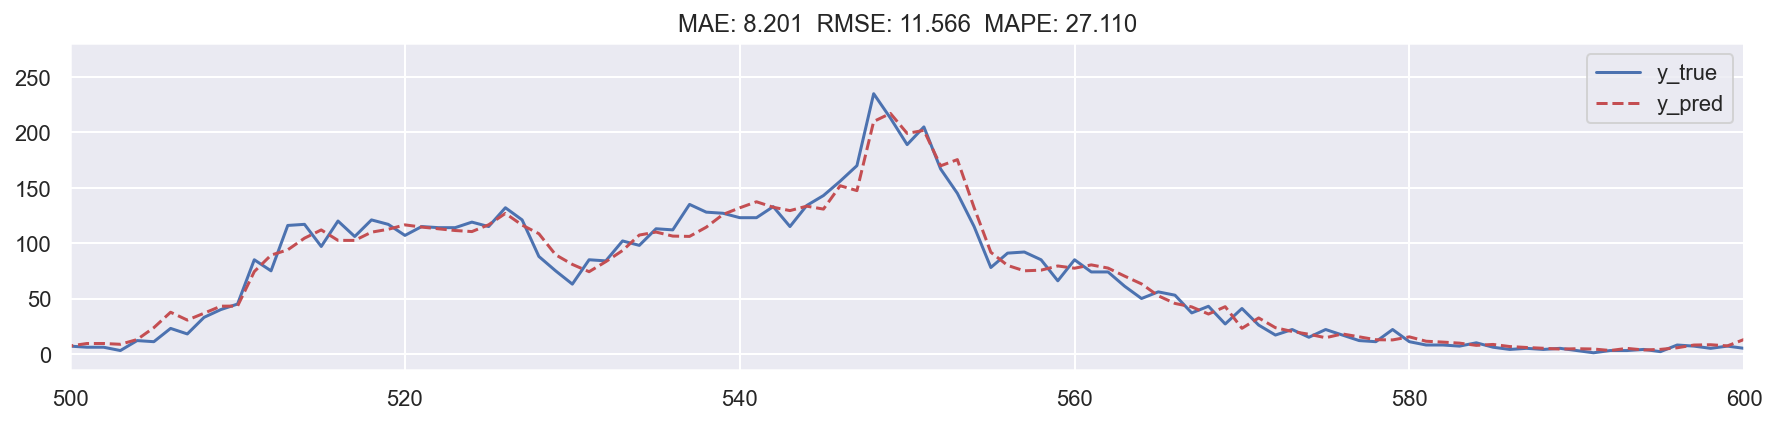

In [28]:
test_y_pred(y_true, y_pred, plot_with_figsize=(15,3))
plt.xlim([500,600])

In [19]:
pd.DataFrame(calc_metrics(y_true, y_pred), index=[0])

,mae,rmse,mape
0,8.201202,11.56589,27.110452


# error

In [29]:
decomposition = seasonal_decompose(ts, period=4*24, two_sided=False)  # 末尾不缺失

trend = decomposition.trend[-test_size:]
seasonal = decomposition.seasonal[-test_size:]
residual = decomposition.resid[-test_size:]

## trend

{'mae': 0.05176284852116915,
 'rmse': 0.07704373245362314,
 'mape': 0.07443114375456933}

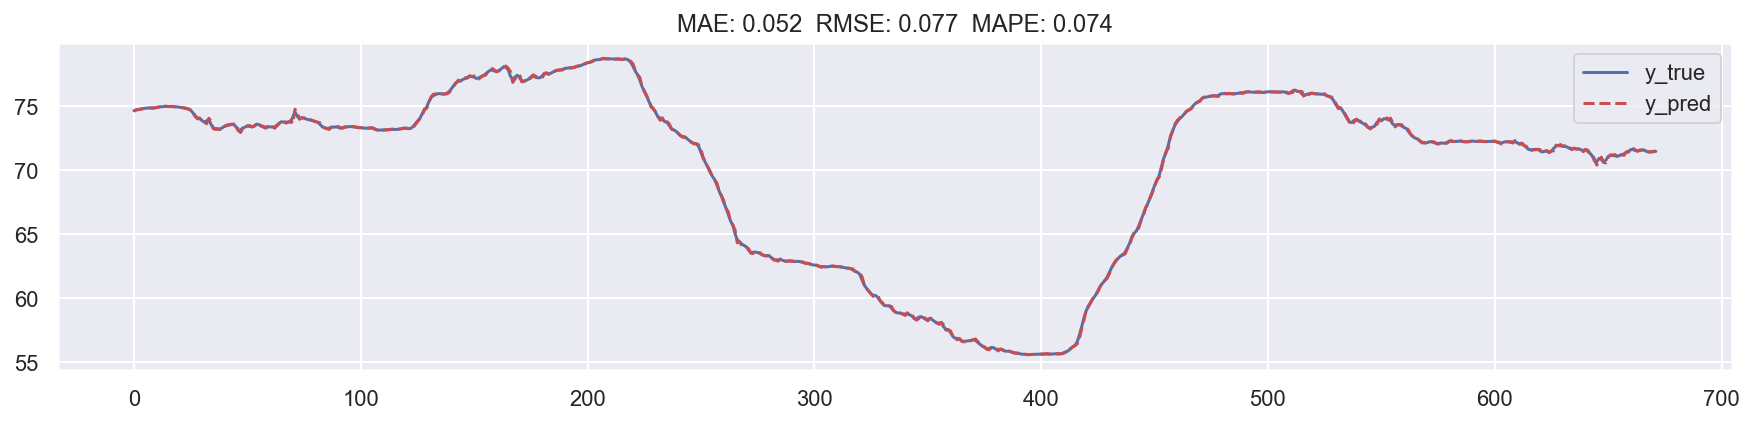

In [32]:
test_y_pred(trend, trend_pred, plot_with_figsize=(15,3))

{'mae': 0.11293777943368125,
 'rmse': 0.17473295741591172,
 'mape': 0.16404067832797892}

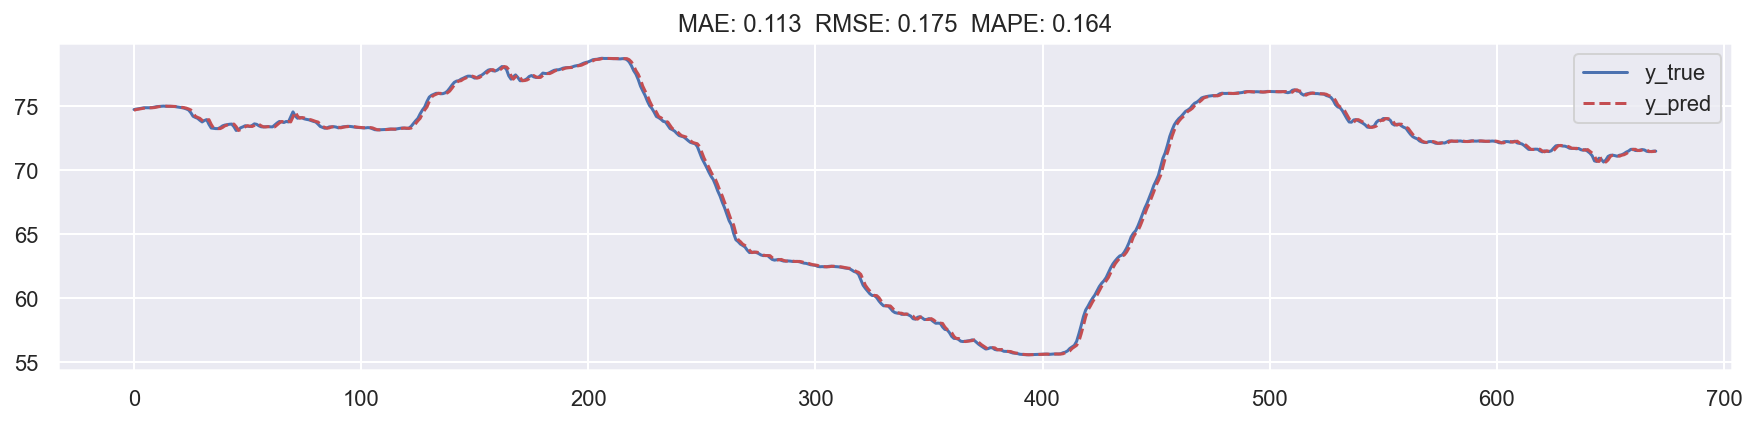

In [40]:
# yhat(t) = y(t-1)
test_y_pred(trend[1:], trend[:-1], plot_with_figsize=(15,3))

## seasonal

{'mae': 0.8945692093092583,
 'rmse': 1.3162205732167092,
 'mape': 1.1571201798735096}

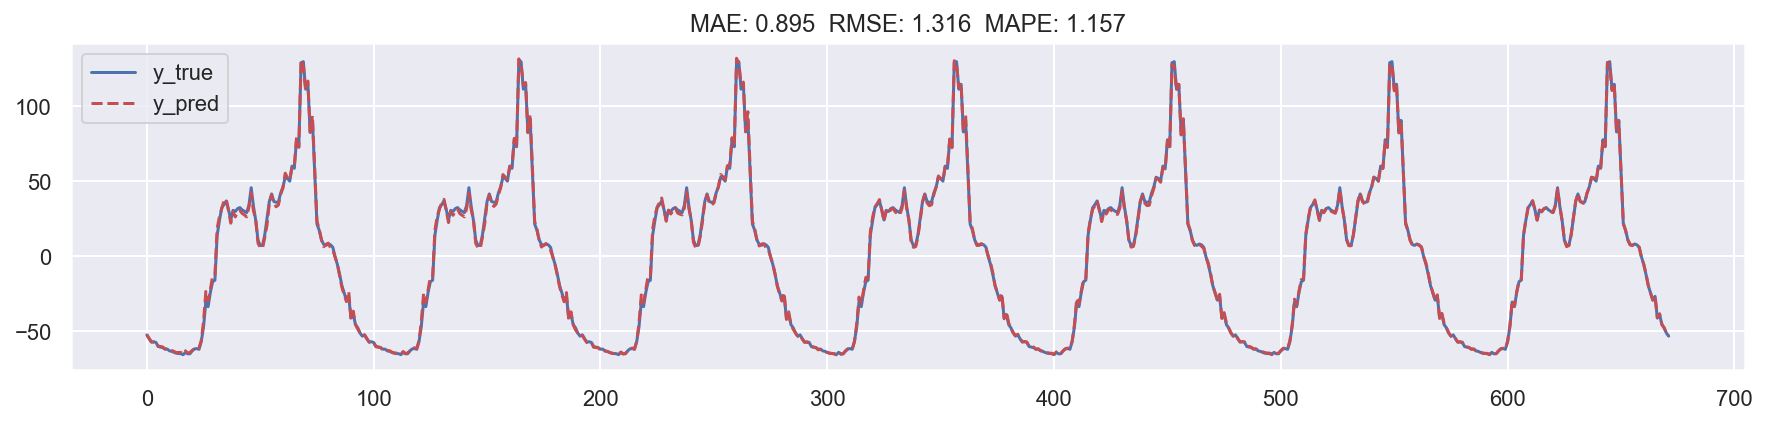

In [33]:
test_y_pred(seasonal, seasonal_pred, plot_with_figsize=(15,3))

## residual

{'mae': 7.802402280330999,
 'rmse': 11.02135769975654,
 'mape': -528.6439627925721}

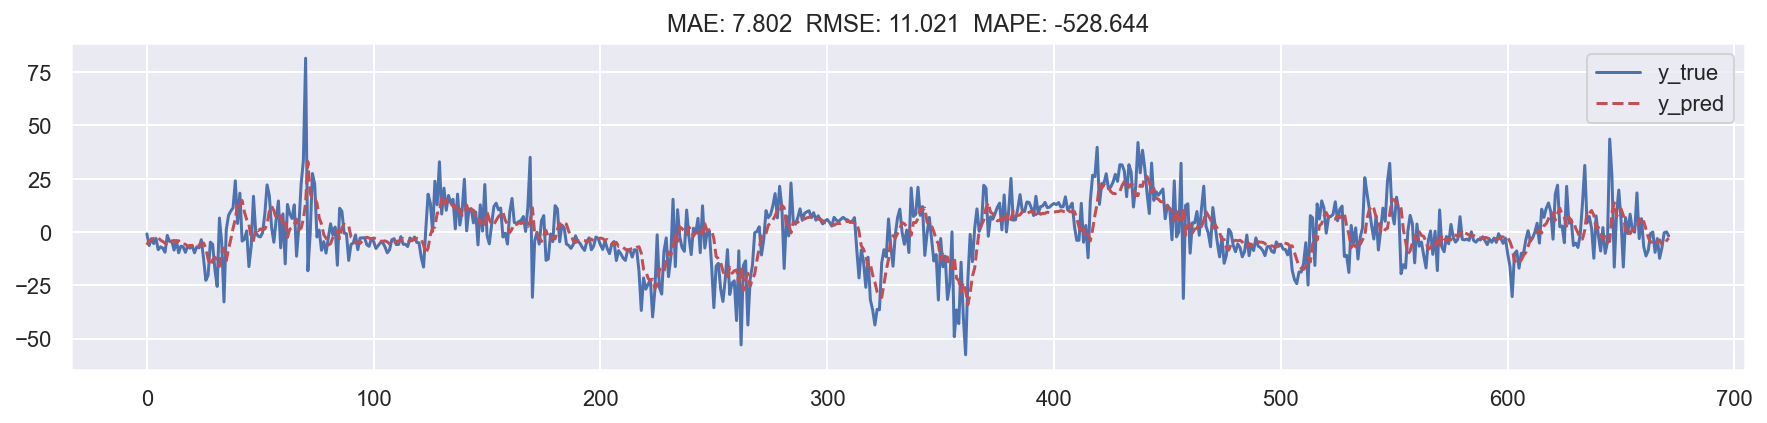

In [48]:
test_y_pred(residual, residual_pred, plot_with_figsize=(15,3))

{'mae': 9.312746244240024,
 'rmse': 13.501236789213081,
 'mape': -759.601972696552}

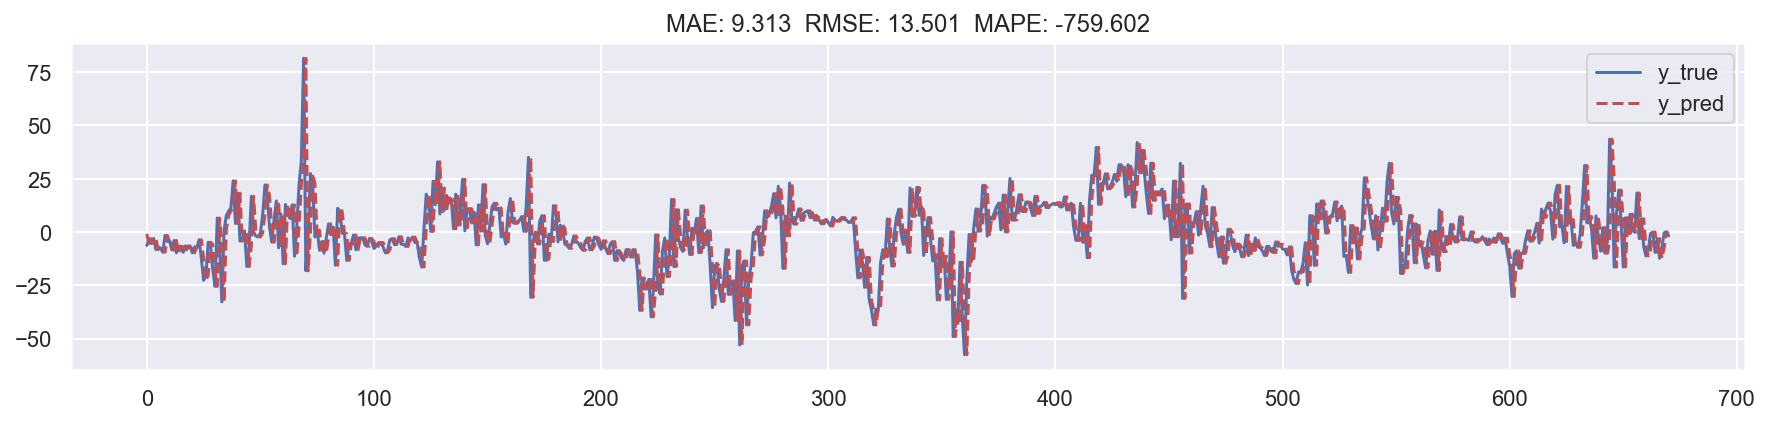

In [45]:
# yhat(t) = y(t-1)
test_y_pred(residual[1:], residual[:-1], plot_with_figsize=(15,3))

{'mae': 7.88211831584208,
 'rmse': 11.295649227235314,
 'mape': -545.8910892979984}

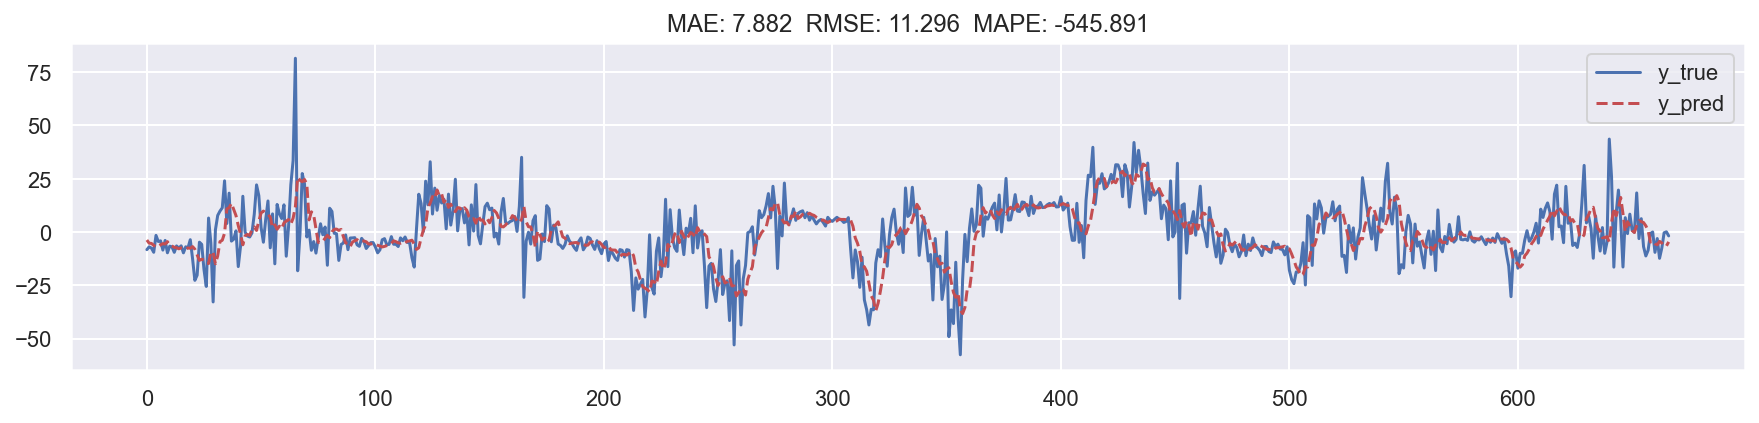

In [59]:
# ma5
test_y_pred(
    residual[5:],
    pd.Series(residual).rolling(5).mean().dropna()[:-1],
    plot_with_figsize=(15,3))

{'mae': 7.847912474663474,
 'rmse': 11.22049740894392,
 'mape': -634.3666006875759}

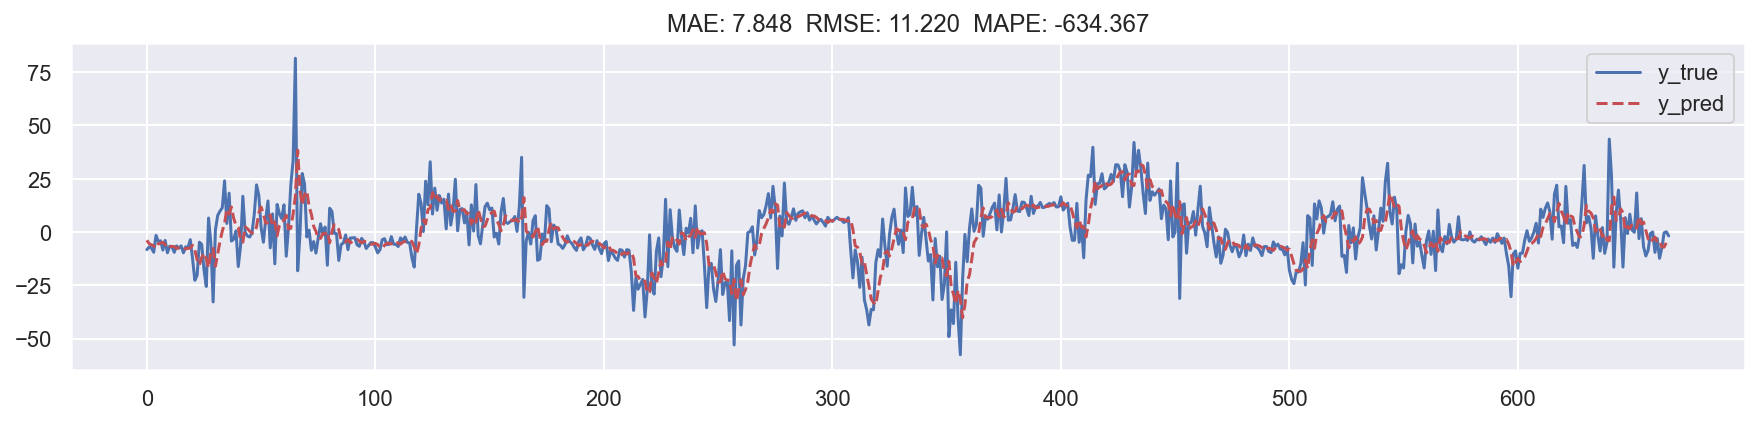

In [63]:
# ema (span=5)
test_y_pred(
    residual[5:],
    pd.Series(residual).ewm(span=5).mean()[4:-1],
    plot_with_figsize=(15,3))

## conclusion

- 对时间序列stl分解，并用arima对trend与residual进行预测，
效果比不分解要好

- 误差主要由residual导致，arima比最傻的办法效果要好，
但是与ma、ema拉不开差距，
还有不少优化空间